<a href="https://colab.research.google.com/github/davidho27941/ML_tutorial_notebook/blob/main/Build_model_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基於TesnorFlow平台的基本模型建立

## 載入必要函式庫以及資料集

為了在`TensorFlow`建立模型，我們需要導入以下函式庫：

* tensorflow 
* tensorflow-datasets

以及常用的資料處理函式庫：

* Numpy 
* Pandas

我們可以透過`tf.test.is_gpu_available()`來確認GPU是否可用，並選擇在CPU或是GPU上運行我們的程式。

In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 匯入MNIST資料集

在此範例中，我們一樣會使用MNIST資料集進行示範。
在載入時，我們需要使用`tensorflow-datasets`的`tfds.load()`函式來抽取MNSIT資料集。並利用經由`tf.data.Dataset`的`map()`方法對資料集進行轉置；最後，我們設定批次數量為64。

我們將分別導入訓練資料集以及測試資料集作為訓練以及測試使用。

In [2]:
train_ds, train_ds_info = tfds.load(name="mnist", 
                    split='train', 
                    with_info=True, 
                    as_supervised=True)

test_ds, test_ds_info = tfds.load(name="mnist", 
                    split='test', 
                    with_info=True, 
                    as_supervised=True)

def preprocess(x, y):
    x = x/255
    x = tf.reshape(x, [784])

    y = tf.one_hot(y, 10)  
    return x, y

train_ds = train_ds.map(lambda x, y: preprocess(x, y)).batch(64)
test_ds = test_ds.map(lambda x, y: preprocess(x, y)).batch(64)

## 建立順序式模型

在`TensorFlow`之中，建立順序是模型可以透過`tf.kears.Sequential()`函式來進行。主要有兩種作作法。

1. 先行建立`model`物件，並透過`model.add()`方法為模型添加結構。
2. 利用`tf.kears.Sequential`建立模型時，直接在參數內填入模型結構。

### 方法一

In [3]:
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.InputLayer(input_shape=(784)))
model_1.add(tf.keras.layers.Dense(128, activation='relu'))
model_1.add(tf.keras.layers.Dense(64, activation='relu'))
model_1.add(tf.keras.layers.Dense(10, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


### 方法二

In [4]:
model_2 = tf.keras.Sequential([
                             tf.keras.layers.InputLayer(input_shape=(784)), 
                             tf.keras.layers.Dense(128, activation='relu'), 
                             tf.keras.layers.Dense(64, activation='relu'), 
                             tf.keras.layers.Dense(10, activation='softmax'),
                            ])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## 設定各項超參數、損失函數以及優化器



In [5]:
EPOCHS = 10 #@param {type:"slider", min:1, max:100, setp: 1}
LR = 1e-2 #@param {type:"number"}
OPTIMIZER = 'adam' #@param ["adam", "SGD"] {type:"raw"}
LOSS_FN = 'binary_crossentropy' #@param ["binary_crossentropy", "categoricalcrossentropy"] {type:"raw"}

if OPTIMIZER == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate = LR)
elif OPTIMIZER == 'SGD':
    momentum = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}
    optimizer = tf.keras.optimizers.SGD(learning_rate = LR, 
                                        momentum = momentum)


## 進行訓練

在建立模型，並設定好超參數以及優化器之後，我們可以利用`model.compile()`對模型進行編譯，並利用`model.fit()`進行訓練。

### 編譯模型

在模型建立之後，我們必須利用`model.compile()`對模型的優化器、損失函數以及評估量尺等選項進行設定。

需要設定的選項如下：

* 優化器（optimizer）
* 損失函數（loss function）
* 評估量尺（metrics）

可選設定如下：
* 損失函數權重（loss weights）
* 權重矩陣（weighted metrics）
* 除錯模式（run_eagerly）

> 更多選項可以至[官方文件](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)了解

In [6]:
model_1.compile(loss = LOSS_FN, 
                optimizer = optimizer, 
                metrics=['acc'])

### 進行訓練

當模型編譯完成後，我們就可以開始進行訓練。訓練的方式為利用`model.fit()`函數搭配相關的參數進行訓練。`model.fit()`在訓練結束後，將會回傳一個帶有訓練歷史資訊的物件，我們可以建立一個`history`變數用以儲存回傳值，並在後續對訓練過程進行了解。

必要的參數有：

* 輸入資料以及標籤（x, y）
* 批次內資料數量（batch_size）
* 週期數量（epochs）
* 顯示模式（verbose）

> 資料輸入的形式以及設定可以參照我們先前的[介紹](https://hackmd.io/@davidho9713/HyfHBzcxY/%2F86N1lvF2SdaRkcnuuWeJTg)

可選設定如下：
* 回測函式（callbacks）
* 驗證資料集以及標籤（validation_data）
* 驗證比例（validation_split）

> 更多的選項可至[官方文件](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)查閱


In [9]:
history = model_1.fit(train_ds, 
            epochs = EPOCHS, 
            verbose = 1,
            )

Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0100 - acc: 0.9859
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0097 - acc: 0.9862
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0104 - acc: 0.9854
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0091 - acc: 0.9865
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0088 - acc: 0.9880
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0078 - acc: 0.9887
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0080 - acc: 0.9884
Epoch 8/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0087 - acc: 0.9881
Epoch 9/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0074 - acc: 0.9898
Epoch 10/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0080 - acc: 0.9889


## 查看學習曲線

在上一個部份，我們對模型進行了訓練，並取得了一個帶有模型訓練資訊的`history`變數。我們可以先透過內建的`__dict__`方法查看`history`物件下帶有哪些資訊。

In [20]:
print(f"Type of history: {type(history)}")

history.__dict__

Type of history: <class 'keras.callbacks.History'>


{'_chief_worker_only': None,
 '_supports_tf_logs': False,
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'history': {'acc': [0.985883355140686,
   0.9861999750137329,
   0.9854000210762024,
   0.9865333437919617,
   0.9879666566848755,
   0.9887333512306213,
   0.9884499907493591,
   0.988099992275238,
   0.989799976348877,
   0.9888833165168762],
  'loss': [0.009955227375030518,
   0.009743010625243187,
   0.010406341403722763,
   0.009098926559090614,
   0.008774219080805779,
   0.007801896892488003,
   0.008027376607060432,
   0.00865394901484251,
   0.007354162633419037,
   0.00796431303024292]},
 'model': <keras.engine.sequential.Sequential at 0x7ff926e2d950>,
 'params': {'epochs': 10, 'steps': 938, 'verbose': 1},
 'validation_data': None}

由上方的執行結果，我們可以得知幾項資訊：

1. `history`變數為`keras.callbacks.History`物件，並非字典物件。雖然可以利用`__dict__`方法將內部資料以字典方式來輸出，但並無法利用字典物件所具有的`.keys()`、`.values()`以及`.items()`方法來提取資訊。

2. `history`變數下的`history`分枝儲存了以下重要資訊：

    * `acc`
    * `loss`

接下來我們將利用`acc`以及`loss`資訊來作圖，顯示訓練中的準確率以及損失值變化。

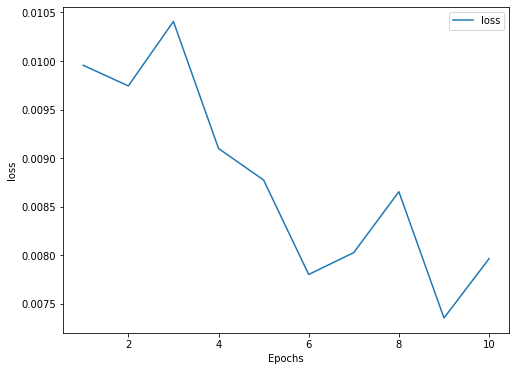

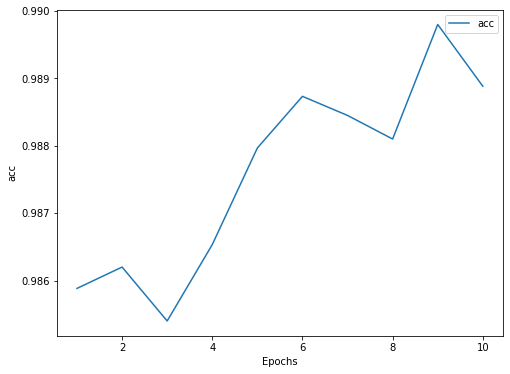

In [22]:
import matplotlib.pyplot as plt

x = [i for i in range(1, EPOCHS+1)]
plt.figure(figsize=(8,6))
plt.plot(x, history.history['loss'], label='loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, history.history['acc'], label='acc')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.show()
